16.512, Homework 5, Johannes Norheim, 11/2

This pset was written in a jupyter notebooks, and has been uploaded online to https://github.com/norheim/rocketscience/blob/master/hw5.ipynb

In [1]:
import numpy as np
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt
from pathlib2 import Path
import pandas as pd
from collections import defaultdict
import subprocess

### Isp with CEA
Instead of running CEA through their website, here is some custom code developed to automatically run it with their command line interface which can be downloaded for windows at https://www.grc.nasa.gov/WWW/CEAWeb/ceaguiDownload-win.htm

First navigate to your installation folder:

In [3]:
#cd ../CEAexec-win

Our goal is to combust ethanol and oxygen, both assumed liquid and at ambient temperature, and find the isp for o/f ratios in the range between 1 and 4. The o/f range discretization can be set below:

In [4]:
discretization = 25
ofarray = np.round(np.linspace(1,4,discretization),2)
ofstring = ','.join(ofarray.astype('str'))

In [5]:
problem = "reac fuel = C2H5OH(L)     wt%=100 t,k=298.15 \n" + \
          "      oxid = N2O4(L)       wt%=100 t,k=298.15 \n" + \
          "prob  rocket  case=test  p,psia =1000, pi/p=68.0272,  eql frozen \n" + \
          "       o/f= "+ofstring+ ",\n" + \
          "output  siunits  massf \n" + \
          "end\n"

We now write this to the input file that CEA requires

In [6]:
problem_name = 'ethanolox'

In [7]:
inputfile_name = problem_name + '.inp'
ceafilein = Path(inputfile_name)
ceafilein.write_text(unicode(problem));

In [8]:
runfilename = "runfile.txt"
runfile = Path(runfilename)
runfile.write_text(unicode(problem_name+"\n"));

We run it:

In [9]:
p = subprocess.Popen(["FCEA2"],
                    stdout=subprocess.PIPE,
                    stdin=runfile.open(),
                    shell=True)

And recover the output

In [10]:
outputfile_name = problem_name + '.out'
ceafileout = Path(outputfile_name)
g = 9.81
isps = defaultdict(list)
with ceafileout.open() as searchfile:
    for line in searchfile:
        if 'ASSUMING EQUILIBRIUM' in line:
            current_bin = 'equilibrium'
        elif 'ASSUMING FROZEN' in line:
            current_bin = 'frozen_flow'
        elif 'Isp' in line:
            parts = line.split()
            exhaust_vel = float(parts[3])
            isp = exhaust_vel / g
            isps[current_bin].append(isp)
        elif 'O/F =' in line:
            parts = line.split()
            of = float(parts[2])
            isps['o/f'].append(of)
isptable = pd.DataFrame.from_dict(isps)

NOTE: we have to divide the value listed as Isp by *g*, since it's technically the exhaust velocity

In [11]:
isptable

,equilibrium,frozen_flow,o/f
0,209.673802,194.230377,1.00
1,215.412844,205.453619,1.12
2,223.027523,217.951070,1.25
3,231.019368,228.195719,1.38
4,238.032620,235.963303,1.50
5,244.220183,242.385321,1.62
6,249.938838,248.032620,1.75
7,254.780836,252.426096,1.88
8,258.583078,255.443425,2.00
9,261.814475,257.482161,2.12


And plot:

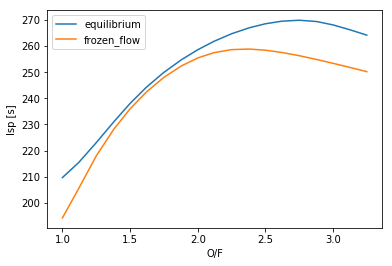

In [12]:
plt.plot(isptable["o/f"],isptable['equilibrium'],isptable["o/f"],isptable['frozen_flow'])
plt.xlabel('O/F')
plt.ylabel('Isp [s]')
plt.legend(['equilibrium', 'frozen_flow'])
plt.show()

### Maximum Isp

We recover the maximum isp, which is different for equilibrium and frozen flow

In [13]:
max_eq_idx = np.where(isptable['equilibrium']==isptable['equilibrium'].max())[0][0]
max_fr_idx = np.where(isptable['frozen_flow']==isptable['frozen_flow'].max())[0][0]

In [14]:
max_ef_of = isptable["o/f"][max_eq_idx]
max_eq = isptable["equilibrium"][max_eq_idx]
max_fr_of = isptable["o/f"][max_fr_idx]
max_fr = isptable["frozen_flow"][max_fr_idx]

In [15]:
print("Equilibrium maximum o/f: {maxof}, isp={isp} s".format(maxof=max_ef_of, isp=round(max_eq,2)))
print("Frozen flow maximum o/f: {maxof}, isp={isp} s".format(maxof=max_fr_of, isp=round(max_fr,2)))

Equilibrium maximum o/f: 2.75, isp=269.89 s
Frozen flow maximum o/f: 2.38, isp=258.86 s


Which when overlaid on the plot looks like the following:

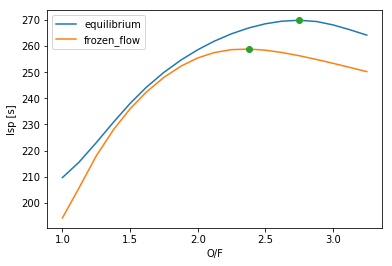

In [16]:
plt.plot(isptable["o/f"],isptable['equilibrium'],isptable["o/f"],isptable['frozen_flow'])
plt.plot([max_ef_of, max_fr_of],[max_eq, max_fr], 'o')
plt.xlabel('O/F')
plt.ylabel('Isp [s]')
plt.legend(['equilibrium', 'frozen_flow'])
plt.show()

### Optimum conditons

If we further investigate the output file from the CEA run for the optimum frozen Isp run we can find the chamber composition, temperature, molecular mass, and frozen $\gamma$:

|   Chamber composition  | Chamber conditions|
|------|------|
| ![ps5chambercomposition.png](ps5chambercomposition.png) | ![ps5chamberconditions.png](ps5chamberconditions.png) |

We get a temperature of 3188.58K, a molecular weight of 24.534 g/mol, and a gamma of 1.2041

### Constant $\gamma$ Isp formulation

Since $P_e=P_a$:

$ Isp = \frac{u_e}{g} $

We know from isentropic flow and conservation of energy that $u_e$, the exit velocity is given by:

$ u_e = \sqrt{2\frac{\gamma}{\gamma-1}\frac{R}{M}T_c \left(1-\left(\frac{P_e}{P_c}\right)^\frac{\gamma-1}{\gamma}\right)} $

If we plug in from the chamber conditions we get:

In [17]:
gamma = 1.2041
Tc = 3188.58
M = 24.524e-3 #kg/ml
R = 8.314 #J/K/mol
PePc = 14.7/1000
ue = np.sqrt(2*(gamma/(gamma-1))*(R/M)*Tc*(1-PePc**((gamma-1)/gamma)))

In [18]:
ue

2552.8324229362324

In [19]:
isp_frozen_theoretical = ue/g

Which gives us the following isps:

In [20]:
print("Theoretical isp : {ispth}s".format(ispth=round(isp_frozen_theoretical,2)))
print("CEA run isp : {isprun} s".format(isprun=round(max_fr,2)))

Theoretical isp : 260.23s
CEA run isp : 258.86 s


Where the theoretically frozen gamma calculation does pretty well at matching up with the frozen flow analysis